In [38]:
import pandas as pd
import numpy as np

import sys
import os

from pathlib import Path
# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [39]:
os.environ["TF_MIN_GPU_MULTIPROCESSOR_COUNT"] = "2"
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

In [40]:
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, AveragePooling1D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import metrics

print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [41]:
features_df = pd.read_csv('./features/features-no-uk-v1.csv')
features_uk_df = pd.read_csv('./features/features-uk-only-v2.csv')

features_df.head()

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,labels
0,0.174738,0.648226,0.677165,0.692260,0.716191,0.665501,0.607874,0.632416,0.642000,0.712695,...,0.008625,0.008645,0.009090,0.010604,0.011772,0.008924,0.003265,0.001107,0.000084,fear
1,0.252287,0.713152,0.745960,0.769096,0.762554,0.728579,0.661987,0.659903,0.686460,0.755400,...,0.011694,0.011428,0.012471,0.013722,0.014640,0.011388,0.005821,0.003910,0.003054,fear
2,0.174738,0.648226,0.677165,0.692260,0.716191,0.665501,0.607874,0.632416,0.642000,0.712695,...,0.008625,0.008645,0.009090,0.010604,0.011772,0.008924,0.003265,0.001107,0.000084,fear
3,0.181625,0.643610,0.581965,0.477430,0.558267,0.605189,0.522657,0.561186,0.614690,0.624254,...,0.183382,0.144932,0.060404,0.048087,0.056380,0.072826,0.076891,0.034622,0.004218,fear
4,0.238893,0.683777,0.635173,0.549861,0.612256,0.639177,0.560762,0.587642,0.635393,0.645892,...,0.184496,0.148167,0.064108,0.050857,0.059945,0.077811,0.082175,0.038339,0.007538,fear


In [42]:
emofilm_uk_df = pd.read_csv('D:/Documents/emofilm/data/emofilm_uk_df.csv')
emofilm_df = pd.read_csv('D:/Documents/emofilm_df.csv')
ravdess_df = pd.read_csv('D:/Documents/ravdess_df.csv')
savee_df = pd.read_csv('D:/Documents/savee_df.csv')
tess_df = pd.read_csv('D:/Documents/tess_df.csv')
cremad_df = pd.read_csv('D:/Documents/cremad_df.csv')

In [43]:
data_df = pd.concat([emofilm_df, emofilm_uk_df, ravdess_df, savee_df, tess_df, cremad_df],
                    axis=0, ignore_index=True)
# data_df = pd.concat([emofilm_df],
#                     axis=0, ignore_index=True)

data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13303 entries, 0 to 13302
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  13303 non-null  object
 1   path     13303 non-null  object
dtypes: object(2)
memory usage: 208.0+ KB


In [44]:
from pandas import DataFrame


def load_raw_data(df: DataFrame, fixed_length: int = -1):
    data = {'data': [], 'emotion': []}
    for i, row in df.iterrows():
        a, sr = librosa.load(path=row['path'])
        if (fixed_length > 0):
            a = librosa.util.fix_length(a, size=fixed_length)
        data['data'].append(a)
        data['emotion'].append(row['emotion'])

    return pd.DataFrame(data)

In [45]:
width3s = int(3*22050)  # duration(s) * sample rate
raw_df = load_raw_data(data_df, width3s)

In [46]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13303 entries, 0 to 13302
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   data     13303 non-null  object
 1   emotion  13303 non-null  object
dtypes: object(2)
memory usage: 208.0+ KB


In [47]:
emotions_number = len(raw_df.emotion.unique())
print(emotions_number)

8


In [48]:
X = np.asarray(raw_df['data'].values)
y = raw_df['emotion'].values

In [49]:
X = np.vstack(X).reshape((len(X), X[0].shape[0], 1))

In [50]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
y = encoder.fit_transform(np.array(y).reshape(-1, 1)).toarray()

In [51]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0, shuffle=True)

print(
    f'train:\t {x_train.shape, y_train.shape,}\ntest:\t{x_test.shape, y_test.shape}')

train:	 ((10642, 66150, 1), (10642, 8))
test:	((2661, 66150, 1), (2661, 8))


In [52]:
# Split once to get the test and validation set
x_val, x_test, y_val, y_test = train_test_split(
    x_test, y_test, test_size=0.3, random_state=42)
print(
    f'val:\t {x_val.shape, y_val.shape,}\ntest:\t{x_test.shape, y_test.shape}')

val:	 ((1862, 66150, 1), (1862, 8))
test:	((799, 66150, 1), (799, 8))


In [53]:
# # scaling our data with sklearn's Standard scaler
# scaler = StandardScaler()
# x_train = scaler.fit_transform(x_train)
# x_test = scaler.transform(x_test)
# x_val = scaler.fit_transform(x_val)
# print(
#     f'train:\t {x_train.shape, y_train.shape,}\ntest:\t{x_val.shape, y_val.shape}\ntest: {x_test.shape, y_test.shape}')

## Model, train


In [54]:
# https://stackoverflow.com/questions/62916904/failed-copying-input-tensor-from-cpu-to-gpu-in-order-to-run-gatherve-dst-tensor
# Fernando Wittmann

class DataGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x, batch_y


train_gen = DataGenerator(x_train, y_train, 32)
val_gen = DataGenerator(x_val, y_val, 32)

vgg9 no uk v1


In [55]:
x_test[0].shape

(66150, 1)

In [56]:
input_shape = x_test[0].shape
print(input_shape)

(66150, 1)


In [57]:
model = Sequential()
model.add(Conv1D(64, kernel_size=11, strides=4, padding='same',
          activation='relu', input_shape=input_shape))
model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))
model.add(Conv1D(64, kernel_size=5, strides=2,
          padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))
model.add(Dropout(0.2))
model.add(Conv1D(128, kernel_size=3, activation='relu'))
model.add(Conv1D(128, kernel_size=3, padding='same', activation='relu'))
model.add(Conv1D(128, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))
model.add(Dropout(0.2))
model.add(Conv1D(256, kernel_size=3, activation='relu'))
model.add(Conv1D(256, kernel_size=3, padding='same', activation='relu'))
model.add(Conv1D(256, kernel_size=3, padding='same', activation='relu'))
model.add(AveragePooling1D(pool_size=2, strides=2, padding='same'))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(units=16, activation='relu'))
model.add(Dense(units=16, activation='relu'))
model.add(Dense(units=emotions_number, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_14 (Conv1D)          (None, 16538, 64)         768       
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 8269, 64)         0         
 1D)                                                             
                                                                 
 conv1d_15 (Conv1D)          (None, 4135, 64)          20544     
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 2068, 64)         0         
 1D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 2068, 64)          0         
                                                                 
 conv1d_16 (Conv1D)          (None, 2066, 128)        

In [58]:
# model = Sequential()
# model.add(Conv1D(64, kernel_size=3, padding='same',
#           activation='relu', input_shape=(x_train.shape[1], 1)))
# model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))
# model.add(Conv1D(128, kernel_size=3, padding='same', activation='relu'))
# model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))
# model.add(Dropout(0.2))
# model.add(Conv1D(256, kernel_size=3, activation='relu'))
# model.add(Conv1D(256, kernel_size=3, padding='same', activation='relu'))
# model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))
# model.add(Dropout(0.2))
# model.add(Conv1D(512, kernel_size=3, activation='relu'))
# model.add(Conv1D(512, kernel_size=3, padding='same', activation='relu'))
# model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))
# model.add(Dropout(0.2))
# model.add(Flatten())
# model.add(Dense(units=64, activation='relu'))
# model.add(Dense(units=64, activation='relu'))
# model.add(Dense(units=emotions_number, activation='softmax'))
# model.compile(optimizer='adam', loss='categorical_crossentropy',
#               metrics=['accuracy'])

# model.summary()

In [59]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4,
                         verbose=0, patience=2, min_lr=0.0000001)


history = model.fit(train_gen, epochs=30,
                    validation_data=val_gen, callbacks=[rlrp])

Epoch 1/30
333/333 [==============================] - 178s 528ms/step - loss: 1.8831 - accuracy: 0.2184 - val_loss: 1.7204 - val_accuracy: 0.2981 - lr: 0.0010
Epoch 2/30
333/333 [==============================] - 174s 523ms/step - loss: 1.7194 - accuracy: 0.3005 - val_loss: 1.6831 - val_accuracy: 0.2970 - lr: 0.0010
Epoch 3/30
333/333 [==============================] - 173s 520ms/step - loss: 1.6746 - accuracy: 0.3133 - val_loss: 1.6603 - val_accuracy: 0.3222 - lr: 0.0010
Epoch 4/30
333/333 [==============================] - 173s 518ms/step - loss: 1.6346 - accuracy: 0.3283 - val_loss: 1.7496 - val_accuracy: 0.2755 - lr: 0.0010
Epoch 5/30
333/333 [==============================] - 173s 521ms/step - loss: 1.5603 - accuracy: 0.3706 - val_loss: 1.5287 - val_accuracy: 0.3867 - lr: 0.0010
Epoch 6/30
333/333 [==============================] - 174s 522ms/step - loss: 1.4831 - accuracy: 0.4047 - val_loss: 1.5543 - val_accuracy: 0.3829 - lr: 0.0010
Epoch 7/30
333/333 [==========================

In [60]:
def print_report(model, history, test_x, test_y):
    print("Accuracy of our model on test data : ",
          model.evaluate(test_x, test_y)[1]*100, "%")

    epochs = history.epoch

    fig, ax = plt.subplots(1, 2)

    train_acc = history.history['accuracy']
    train_loss = history.history['loss']
    test_acc = history.history['val_accuracy']
    test_loss = history.history['val_loss']

    fig.set_size_inches(20, 6)
    ax[0].plot(epochs, train_loss, label='Training Loss')
    ax[0].plot(epochs, test_loss, label='Testing Loss')
    ax[0].set_title('Training & Testing Loss')
    ax[0].legend()
    ax[0].set_xlabel("Epochs")
    ax[1].plot(epochs, train_acc, label='Training Accuracy')
    ax[1].plot(epochs, test_acc, label='Testing Accuracy')
    ax[1].set_title('Training & Testing Accuracy')
    ax[1].legend()
    ax[1].set_xlabel("Epochs")

    plt.show()

In [61]:
def print_confusion_matrix(test, pred, size=(12, 10)):
    cm = confusion_matrix(test, pred)
    plt.figure(figsize=size)
    cm = pd.DataFrame(cm, index=[i for i in encoder.categories_], columns=[
        i for i in encoder.categories_])
    sns.heatmap(cm, linecolor='white', cmap='Blues',
                linewidth=1, annot=True, fmt='')
    plt.title('Confusion Matrix', size=20)
    plt.xlabel('Predicted Labels', size=14)
    plt.ylabel('Actual Labels', size=14)
    plt.show()

25/25 [==============================] - 5s 196ms/step - loss: 1.9586 - accuracy: 0.4643
Accuracy of our model on test data :  46.433040499687195 %


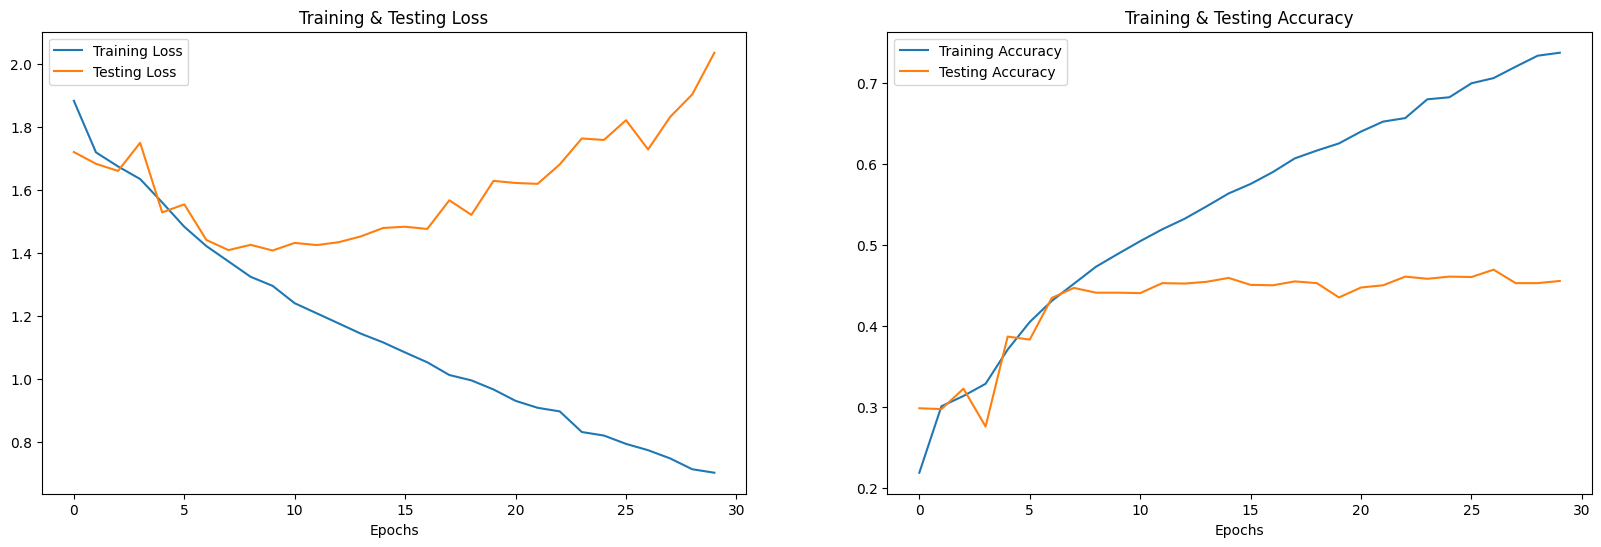

In [62]:
print_report(model, history, x_test, y_test)

In [63]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test_decoded = encoder.inverse_transform(y_test)

25/25 [==============================] - 4s 163ms/step


In [64]:
# df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
# df['Predicted Labels'] = y_pred.flatten()
# df['Actual Labels'] = y_test_decoded.flatten()

# df.head(10)

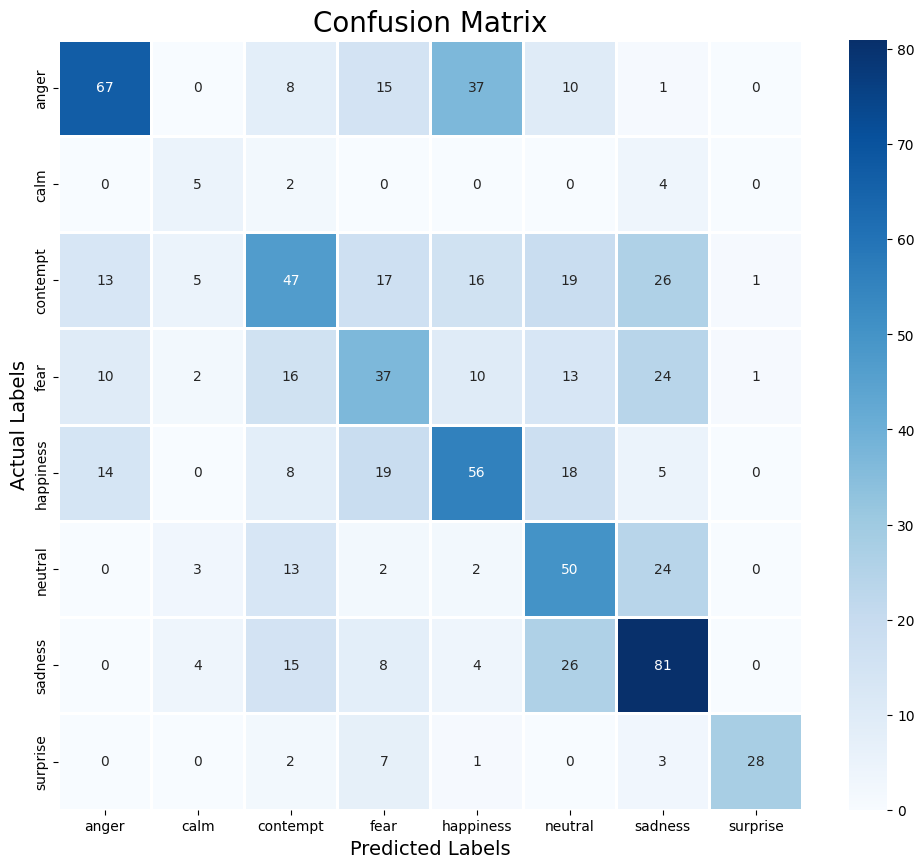

In [65]:
print_confusion_matrix(y_test_decoded, y_pred)

In [66]:
print(classification_report(y_test_decoded, y_pred))

              precision    recall  f1-score   support

       anger       0.64      0.49      0.55       138
        calm       0.26      0.45      0.33        11
    contempt       0.42      0.33      0.37       144
        fear       0.35      0.33      0.34       113
   happiness       0.44      0.47      0.46       120
     neutral       0.37      0.53      0.43        94
     sadness       0.48      0.59      0.53       138
    surprise       0.93      0.68      0.79        41

    accuracy                           0.46       799
   macro avg       0.49      0.48      0.48       799
weighted avg       0.48      0.46      0.47       799



## Save model


In [21]:
model.save('./saved_models/ser-main-v4-no-uk.keras')

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()


with open('./saved_models/ser-main-v4-no-uk.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\nicko\AppData\Local\Temp\tmpaqopaohn\assets


INFO:tensorflow:Assets written to: C:\Users\nicko\AppData\Local\Temp\tmpaqopaohn\assets


metadata (skip for now)


In [22]:
# from tflite_support import flatbuffers
# from tflite_support import metadata as _metadata
# from tflite_support import metadata_schema_py_generated as _metadata_fb

# # Creates model info.
# model_meta = _metadata_fb.ModelMetadataT()
# model_meta.name = "Speech emotion recognition"
# model_meta.description = ("Identify emotion of human voice")
# model_meta.version = "v2"
# model_meta.author = "Mykola Nosenko"
# model_meta.license = ("Apache License. Version 2.0 "
#                       "http://www.apache.org/licenses/LICENSE-2.0.")  # verify later

In [23]:
# # Creates output info.
# output_meta = _metadata_fb.TensorMetadataT()
# output_meta.name = "probability"
# output_meta.description = "Probabilities of the 8 labels respectively."
# output_meta.content = _metadata_fb.ContentT()
# output_meta.content.content_properties = _metadata_fb.FeaturePropertiesT()
# output_meta.content.contentPropertiesType = (
#     _metadata_fb.ContentProperties.FeatureProperties)
# output_stats = _metadata_fb.StatsT()
# output_stats.max = [1.0]
# output_stats.min = [0.0]
# output_meta.stats = output_stats
# label_file = _metadata_fb.AssociatedFileT()
# label_file.name = os.path.basename("./emotion_labels.txt")
# label_file.description = "Labels for emotions that the model can recognize."
# label_file.type = _metadata_fb.AssociatedFileType.TENSOR_AXIS_LABELS
# output_meta.associatedFiles = [label_file]

In [24]:
# # Creates subgraph info.
# subgraph = _metadata_fb.SubGraphMetadataT()
# # subgraph.inputTensorMetadata = [input_meta]
# subgraph.outputTensorMetadata = [output_meta]
# model_meta.subgraphMetadata = [subgraph]

# b = flatbuffers.Builder(0)
# b.Finish(
#     model_meta.Pack(b),
#     _metadata.MetadataPopulator.METADATA_FILE_IDENTIFIER)
# metadata_buf = b.Output()

In [25]:
# populator = _metadata.MetadataPopulator.with_model_file('./model.tflite')
# populator.load_metadata_buffer(metadata_buf)
# populator.load_associated_files(["./emotion_labels.txt"])
# populator.populate()

In [26]:
# displayer = _metadata.MetadataDisplayer.with_model_file(
#     "./model.tflite")
# export_json_file = os.path.join("D:/Documents/export_models/model.json")
# json_file = displayer.get_metadata_json()
# # Optional: write out the metadata as a json file
# with open(export_json_file, "w") as f:
#     f.write(json_file)

In [27]:
# # Convert the model
# converter = tf.lite.TFLiteConverter.from_saved_model(
#     "./saved_models/ser4.keras")  # path to the SavedModel directory
# tflite_model = converter.convert()

# # Save the model.
# with open('ser4-model.tflite', 'wb') as f:
#     f.write(tflite_model)

## Test model


In [28]:
# model_l = tf.keras.models.load_model('./saved_models/ser4-v4.keras')
# model_l.summary()

In [21]:
X_uk = features_uk_df.iloc[:, :-1].values
y_uk = features_uk_df['labels'].values

In [22]:
fear_label = 'fear'
contempt_label = 'contempt'  # disgust
happiness_label = 'happiness'
anger_label = 'anger'
sadness_label = 'sadness'
neutral_label = 'neutral'
surprise_label = 'surprise'
calm_label = 'calm'

emotions = [fear_label, contempt_label, happiness_label, anger_label,
            sadness_label, neutral_label, surprise_label, calm_label]

In [23]:
encoder_uk = OneHotEncoder(categories=[emotions])
y_uk = encoder_uk.fit_transform(np.array(y_uk).reshape(-1, 1)).toarray()

In [24]:
loss, acc = model.evaluate(X_uk, y_uk, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

3/3 - 0s - loss: 9.2090 - accuracy: 0.0897 - 451ms/epoch - 150ms/step
Restored model, accuracy:  8.97%


In [25]:
pred_uk = model.predict(X_uk)
pred_uk_decoded = encoder_uk.inverse_transform(pred_uk)
y_uk_decoded = encoder_uk.inverse_transform(y_uk)
print(pred_uk_decoded.shape)
print(y_uk_decoded.shape)

3/3 [==============================] - 0s 7ms/step
(78, 1)
(78, 1)


In [26]:
cm = confusion_matrix(y_uk_decoded, pred_uk_decoded)
cm

array([[ 0,  0,  0,  6,  0,  0,  0,  3],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 5,  5,  0,  3,  7,  2,  0, 14],
       [ 0,  0,  0,  0,  3,  0,  0,  3],
       [ 2,  3,  0,  0,  7,  0,  5,  7],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  3],
       [ 0,  0,  0,  0,  0,  0,  0,  0]], dtype=int64)

In [27]:
print(classification_report(y_uk_decoded, pred_uk_decoded))

              precision    recall  f1-score   support

       anger       0.00      0.00      0.00         9
        calm       0.00      0.00      0.00         0
    contempt       0.00      0.00      0.00        36
        fear       0.00      0.00      0.00         6
   happiness       0.41      0.29      0.34        24
     neutral       0.00      0.00      0.00         0
     sadness       0.00      0.00      0.00         3
    surprise       0.00      0.00      0.00         0

    accuracy                           0.09        78
   macro avg       0.05      0.04      0.04        78
weighted avg       0.13      0.09      0.11        78



In [28]:
from model_analyzer import get_model_memory_usage


print(f'Memory usage: {get_model_memory_usage(32, model)} GB')

Memory usage: 0.019 GB
